## A jupyter notebook to plot a graph depicting the salinecy maps of an already trained model

This notebook will follow (somewhat) the steps described in the following paper (https://arxiv.org/abs/1506.01066) and tutorial (https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338)

In [1]:
""" 

https://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py#L164

https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338

https://www.quora.com/How-is-a-saliency-map-generated-when-training-recurrent-neural-networks-with-soft-attention
"""

' \n\nhttps://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py#L164\n\nhttps://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338\n\nhttps://www.quora.com/How-is-a-saliency-map-generated-when-training-recurrent-neural-networks-with-soft-attention\n'

In [2]:
# https://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py
# https://discuss.pytorch.org/t/how-to-plot-saliency-map-from-rnn-model-in-nlp-task/82338
# https://arxiv.org/abs/1506.01066

# import the necessary libraries
import numpy as np
import torch
from torch.jit import RecursiveScriptModule
# import torch Variable
from torch.autograd import Variable

#! DISCLAIMER: For these following imports, you have to add the following node to the VSCode settings.json file:
# "jupyter.notebookFileRoot": "${workspaceFolder}",

# import the necessary functions RNNModelTrain module
from src.RNNModelTrain.data import load_data
from src.RNNModelTrain.utils import load_model, set_seed


In [3]:
class RNNModel(torch.nn.Module):
    def __init__(self,
                 embedding_weights: torch.Tensor,
                 hidden_size: int,
                 num_layers: int
                 ) -> None:
        """
        This method is the constructor of the class.

        Args:
            embedding_weights: weights for the embedding layer
            hidden_size: size of the hidden state of the RNN
            num_layers: number of RNN layers
            device: device to run the model
        """

        # TODO
        super().__init__()
        torch.set_default_dtype(torch.float32)  # set dtype to float32

        embedding_dim = embedding_weights.shape[1]
        
        self.rnn: torch.nn.RNN = torch.nn.RNN(
            embedding_dim, hidden_size, num_layers, batch_first=True)

        self.fc: torch.nn.Linear = torch.nn.Linear(hidden_size, 1)

    def forward(self, embedded: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        """
        This method is the forward pass of the model.

        Args:
            inputs: inputs tensor. Dimensions: [batch, ].
            text_lengths: lengths of the texts. Dimensions: [batch].

        Returns:
            output tensor. Dimensions: [batch, ].
        """

        packed_embedding = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False)

        packed_output, hidden = self.rnn(packed_embedding)

        last_hidden: torch.Tensor = hidden[-1]

        return self.fc(last_hidden).squeeze(1)


In [4]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, Tuple
import torch.nn as nn
import torch.optim as optim

from src.RNNModelTrain.utils import calculate_accuracy

def train_torch_model(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int,
    print_every: int,
    patience: int,
    writer: SummaryWriter,
    embedding_weights: torch.Tensor,
    device: str = 'cpu'
) -> Tuple[Dict[int, float], Dict[int, float]]:
    """
    Train and validate the logistic regression model.

    Args:
        model (torch.nn.Module): An instance of the model to be trained.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        val_dataloader (DataLoader): DataLoader for the validation dataset.
        learning_rate (float): The learning rate for the optimizer.
        criterion (nn.Module): Loss function to use for training.
        optimizer (optim.Optimizer): Optimizer to use for training.
        epochs (int): The number of epochs to train the model.
        print_every (int): Frequency of epochs to print training and validation loss.
        patience (int): The number of epochs to wait for improvement on the validation loss before stopping training early.
        device (str): device where to train the model.

    Returns:
        Tuple[Dict[int, float],Dict[int, float]]: Dictionary of accuracies at each `print_every` interval for the training and validation datasets.
    """
    # TODO: Initialize dictionaries to store training and validation accuracies
    train_accuracies: Dict[int, float] = {}  # epoch: accuracy
    val_accuracies: Dict[int, float] = {}  # epoch: accuracy

    # TODO: Initialize variables for Early Stopping
    best_loss: float = float('inf')
    epochs_no_improve: int = 0

    # TODO: Move the model to the specified device (CPU or GPU)
    model.to(device)

    embedding: torch.nn.Embedding = torch.nn.Embedding.from_pretrained(
        embedding_weights)
    
    # send the embedding to the device
    embedding.to(device)
    

    # TODO: Implement the training loop over the specified number of epochs
    for epoch in range(epochs):
        # TODO: Set the model to training mode
        model.train()

        total_loss: float = 0.0

        # TODO: Implement the loop for training over each batch in the training dataloader
        for features, labels, text_len in train_dataloader:

            # TODO: Move features and labels to the specified device
            features, labels = features.to(device), labels.to(device)

            # embed the features
            embedded_inputs: torch.Tensor = embedding(features)
    
            # TODO: Clear the gradients
            optimizer.zero_grad()

            # TODO: Forward pass (compute the model output)
            output = model(embedded_inputs, text_len)

            # TODO: Compute the loss
            # cast labels to float to avoid a data type mismatch error
            loss = criterion(output, labels.float())

            # TODO: Backward pass (compute the gradients)
            loss.backward()

            # TODO: Update model parameters
            optimizer.step()

            # TODO: Accumulate the loss
            total_loss += loss.item()

        # TODO: Implement the evaluation phase
        model.eval()
        val_loss: float = 0.0

        with torch.no_grad():
            # TODO: Loop over the validation dataloader
            for features, labels, text_len in val_dataloader:

                # TODO: Move features and labels to the specified device
                features, labels = features.to(device), labels.to(device)

                # embed the features
                embedded_inputs: torch.Tensor = embedding(features)
                
                                
                # TODO: Forward pass (compute the model output)
                output = model(embedded_inputs, text_len)

                # TODO: Compute the loss
                loss = criterion(output, labels.float())

                # TODO: Accumulate validation loss
                val_loss += loss.item()

        """# TODO: Calculate training and validation accuracy
        train_accuracy = calculate_accuracy(
            model, train_dataloader, device=device)
        val_accuracy = calculate_accuracy(
            model, val_dataloader, device=device)

        # TODO: Store accuracies
        train_accuracies[epoch] = train_accuracy
        val_accuracies[epoch] = val_accuracy

        # write the training loss to tensorboard
        writer.add_scalar("Loss/train", total_loss /
                          len(train_dataloader), epoch)
        writer.add_scalar("Loss/val", val_loss / len(val_dataloader), epoch)
        writer.add_scalar("Accuracy/train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)

        # TODO: Print training and validation results every 'print_every' epochs
        if epoch % print_every == 0 or epoch == epochs - 1:
            # TODO: Calculate and print average losses and accuracies
            avg_train_loss = total_loss / len(train_dataloader)
            avg_val_loss = val_loss / len(val_dataloader)
            print(f"Epoch {epoch} -> \
                    Train Loss: {avg_train_loss:.4f}, \
                    Val Loss: {avg_val_loss:.4f}, \
                    Train Acc: {train_accuracy:.4f}, \
                    Val Acc: {val_accuracy:.4f}")"""

        # TODO: Implement Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return None, None # train_accuracies, val_accuracies

In [5]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from typing import Final, Dict

from src.RNNModelTrain.utils import set_seed, plot_accuracies
from src.RNNModelTrain.data import load_data
#from src.RNNModelTrain.train_functions import train_torch_model

from gensim.models.keyedvectors import load_word2vec_format

SEED: Final[int] = 2222
set_seed(SEED)

DATA_PATH: Final[str] = "./NLP_Data/data"

batch_size: int = 16
epochs: int = 3
print_every: int = 1
patience: int = 5
learning_rate: float = 1e-4
hidden_dim: int = 256
num_layers: int = 1

dataset_name: str = "IMDB"  # "TweepFake"  #

model_name = f"{dataset_name}_rnn_hidden_{hidden_dim}_lr_{learning_rate}_epochs_{epochs}" + \
    f"_batch_{batch_size}_patience_{patience}"

# TODO: Check if GPU is available and move the model to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on {device}")
print(f"Training on dataset: {dataset_name}")


Training on cuda
Training on dataset: IMDB


In [6]:
print("Loading data...")
# load the data
train_dataloader: DataLoader
val_dataloader: DataLoader
test_dataloader: DataLoader
(
    train_dataloader,
    val_dataloader,
    test_dataloader
) = load_data(save_path=DATA_PATH, dataset_name=dataset_name, batch_size=batch_size)

print("Loading embeddings...")
w2v_model = load_word2vec_format(
    "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)

embedding = torch.nn.Embedding.from_pretrained(embedding_weights)

Loading data...
Loading embeddings...


Definition of constants & parameters

In [7]:
print("Initailizing model...")
# initialize the model
model = RNNModel(embedding_weights=embedding_weights,
                    hidden_size=hidden_dim,
                    num_layers=num_layers).cuda()

print("Initializing optimizer and loss function...")
# initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# initialize the loss function (BCE with logits loss)
loss_fn = torch.nn.BCEWithLogitsLoss()

# initialize the summary writer
writer = SummaryWriter()

train_accuracies: Dict[int, float]
val_accuracies: Dict[int, float]

print("STARTING TRAINING PROCESS...")
# train the model
(
    train_accuracies,
    val_accuracies
) = train_torch_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=loss_fn,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every,
    patience=patience,
    writer=writer,
    embedding_weights=embedding_weights,
    device=device)


Initailizing model...
Initializing optimizer and loss function...
STARTING TRAINING PROCESS...


In [8]:
model

RNNModel(
  (rnn): RNN(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# get the first batch from the test dataloader
dataiter = iter(test_dataloader)
out = dataiter._next_data()

In [10]:
texts, targets, lens = out
#print(out)

In [11]:
# set the dtype to be float
texts = texts.int().cuda()
lengths = lens.int() #.cuda()

embedding.to(device)

# embed the features
embedded_inputs: torch.Tensor = embedding(texts)

embedded_inputs.requires_grad = True

packed_embedding: torch.nn.utils.rnn.PackedSequence = torch.nn.utils.rnn.pack_padded_sequence(
    embedded_inputs, lengths, batch_first=True, enforce_sorted=False)

packed_embedding.requires_grad = True # set requires_grad to True

In [12]:
# set the model to train mode (necessary to get the gradients)
model.cuda()
model.train()

RNNModel(
  (rnn): RNN(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [13]:
# get the gradients of the model
model.zero_grad()

In [14]:
# find the gradient of the model with respect to the input
out = model(embedded_inputs, lengths)
print(out.shape)
out = out.squeeze()
print(out)

torch.Size([16])
tensor([-2.1326, -2.2826,  2.1529, -1.8395,  0.2538, -2.1598,  2.0047,  1.4181,
        -1.9321,  1.6198,  0.6949,  0.2920, -1.2028, -0.1400, -0.9709, -1.3634],
       device='cuda:0', grad_fn=<SqueezeBackward0>)


In [15]:
# get the loss
loss = loss_fn(out, targets.cuda().float())
loss.backward()


In [16]:
# get the gradients of the model with respect to the input of the model
gradients = embedded_inputs.grad
print(gradients)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-2.5546e-04,  1.6982e-04, -1.9194e-04,  ...,  9.5754e-05,
           2.3361e-04, -2.5198e-04],
         [-3.4772e-04,  9.4073e-05, -2.7463e-04,  ...,  9.5457e-05,
           2.1351e-04, -9.8407e-05],
         [-2.7065e-04, -1.7975e-05, -2.2045e-04,  ...,  8.1984e-05,
           4.6074e-04, -3.3086e-04]],

        [[-1.0199e-19,  3.2403e-20, -7.9513e-20,  ...,  4.1094e-20,
           1.0850e-19, -7.8857e-20],
         [-9.9784e-20,  2.9950e-20, -7.8730e-20,  ...,  4.0247e-20,
           1.0571e-19, -7.5608e-20],
         [-9.7071e-20,  3.1318e-20, -7.6890e-20,  ...,  3.9236e-20,
           1.0180e-19, -7.2979e-20],
         ...,
         [ 0.0000e+00,  0

In [17]:
print(embedded_inputs.grad.shape)

torch.Size([16, 986, 300])


In [18]:
print(embedded_inputs.shape)

torch.Size([16, 986, 300])


In [19]:
# construct the sentences used in the batch
print(texts)
sentences = []
for text in texts:
    sentence = ""
    for word in text:
        sentence += w2v_model.index_to_key[word.item()] + " "
    sentences.append(sentence)

tensor([[    427,      20,      75,  ...,      11, 1715328,   80556],
        [    382,     284,   31276,  ...,       0,       0,       0],
        [ 108016,       0,    1533,  ...,       0,       0,       0],
        ...,
        [     20,      76,     193,  ...,       0,       0,       0],
        [   5183,       0,    4960,  ...,       0,       0,       0],
        [ 108796,  108796,      51,  ...,       0,       0,       0]],
       device='cuda:0', dtype=torch.int32)


In [20]:
print(len(sentences))
for s in sentences:
    print(s)
    print()

16
All I could think while watching this movie was Will it ever end It was unbearably boring </s> watch I was wishing I could just turn it off but I wanted </s> do this review justice so I fought the good fight </s> withstood the torture </s> watching this movie all the way through so that you the good reader need not bear that pain </s> br This movie sounds like it has </s> great premise if you read the premise on paper However the actual movie does not deliver on this premise at </s> br The opening scene features </s> mineshaft in the early </s> where they are forcing kids </s> carry dynamite into the tunnels that arent big enough for the adults </s> fit into This seems </s> be setting up the premise for an interesting movie But after 4 minutes it becomes clear that is not the case The adults who committed these crimes are never punished there is no consequences shown in the movie for their actions The opening scene is way better than </s> completely irrelevant </s> the rest </s> the

In [21]:
# now we will have to calculate the saliency map
# the saliency map is the gradient of the output with respect to the input
# we will color the words in the sentence based on the saliency map
# the more red the word is, the more important it is for the output
# the more blue the word is, the less important it is for the output
import matplotlib.pyplot as plt
import numpy as np

# get the index with the lowest sentence length
idx = -1


# get the saliency map
saliency = gradients[idx].data.abs().squeeze()
saliency_list = saliency.detach().cpu().numpy()

#print(saliency_list.shape)
#print(saliency.shape)

# get the output of the model
output = torch.sigmoid(out)
#print(output)
#print(output.shape)
output = output.detach().cpu().numpy()




# get the words in the sentence
words = [w2v_model.index_to_key[word.item()] for word in texts[idx]]

# print the words
print(words)
# remove the "</s>" tokens
useful_words = [word for word in words if word not in ("</s>", "br")]

# generate a list of 1 for each word different from "</s>", otherwise 0
useful_words_indices = []
for word in words:
    if word != "</s>":
        useful_words_indices.append(1)
    else:
        useful_words_indices.append(0)
#print(useful_words_indices)

# filter the saliency list where the indices are different from 0
saliencies = []
for i in range(len(useful_words_indices)):
    if useful_words_indices[i] == 1:
        saliencies.append(saliency_list[i])
        
#print(saliencies)
print(len(saliencies))
print(len(useful_words))

saliency_list = np.array(saliencies)
#print(saliency_list)





['br', 'br', 'It', '</s>', 'the', 'worst', 'movie', 'that', 'I', 'have', 'ever', 'seen', 'However', 'that', 'is', 'only', 'if', 'I', 'get', '</s>', 'count', 'home', 'movies', 'made', 'by', '8', 'year', 'olds', 'This', 'movie', 'was', 'horrible', 'from', 'start', '</s>', 'finish', 'Nothing', 'about', 'it', 'made', 'it', 'worth', 'watching', 'unless', 'you', 'wanted', '</s>', 'show', 'new', 'filmmakers', 'how', 'not', '</s>', 'make', '</s>', 'film', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s

In [22]:
# print the lens of saliency_list, useful_words and words
print(len(saliency_list))
print(len(useful_words))
print(len(words))
print(saliency_list.shape)

# find the norm of each element in the saliency list
saliency_list_module = np.linalg.norm(saliency_list, axis=1)
print(saliency_list_module.shape)
print(saliency_list_module)
# add a second empty dimension to the saliency list module
saliency_list_module = np.expand_dims(saliency_list_module, axis=1)

50
50
986
(50, 300)
(50,)
[0.00120637 0.00118341 0.00116179 0.00109578 0.00106089 0.00104095
 0.00102562 0.00100833 0.0009896  0.00097478 0.00095643 0.00094069
 0.00092883 0.00091442 0.00089554 0.00087985 0.00087067 0.0008614
 0.00084888 0.00085453 0.00085365 0.00085574 0.00086362 0.00087747
 0.00089732 0.00091559 0.00093853 0.00096559 0.00099949 0.00104328
 0.00115104 0.0012827  0.00160049 0.00179321 0.002073   0.00238644
 0.00272528 0.00313248 0.00359329 0.00402802 0.00444344 0.00503539
 0.00561421 0.00678584 0.00736048 0.00771376 0.00800563 0.0084313
 0.01010045 0.01092361]


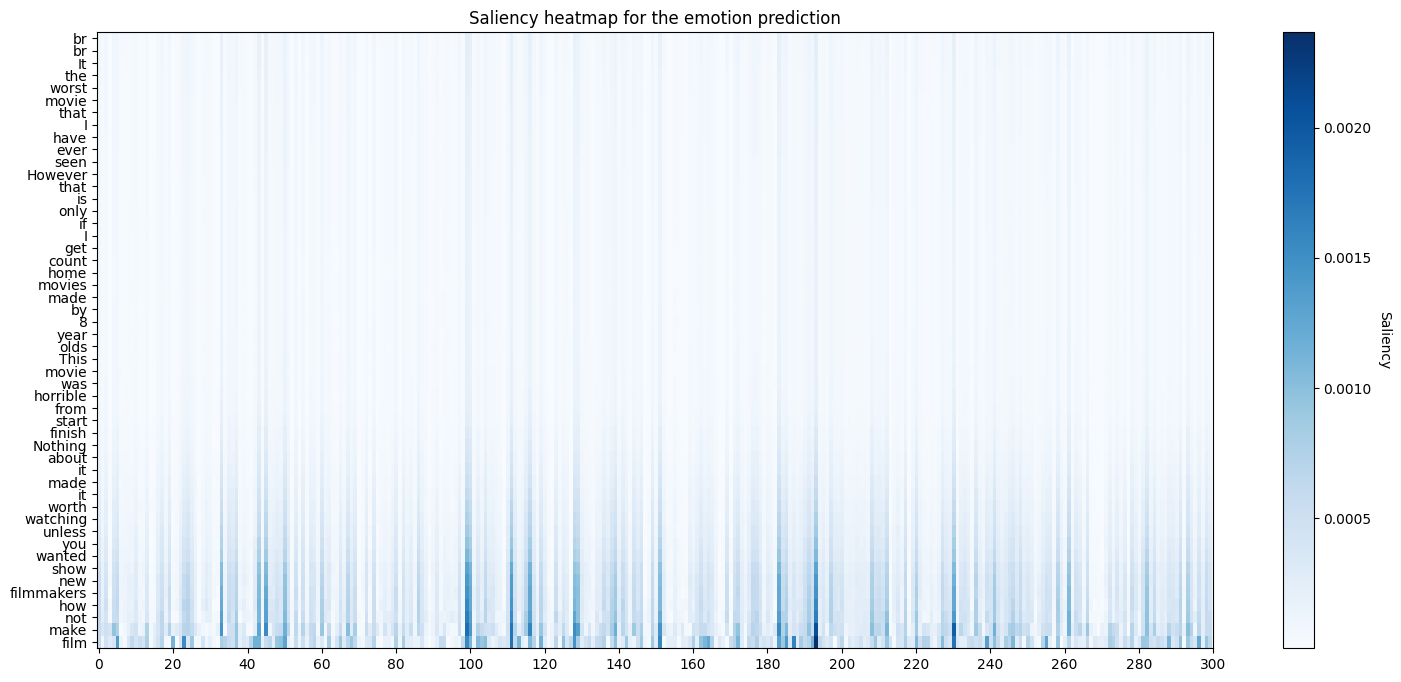

In [30]:
# create the figure
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
ax.set_aspect(aspect=2)
im = plt.imshow(saliency_list, aspect='auto', interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Saliency", rotation=-90, va="bottom")
ax.set_yticks(np.arange(len(useful_words)))
ax.set_xticks(np.arange(len(saliency_list[0])+1, step=20))
ax.set_yticklabels(useful_words) # useful_words
ax.set_title("Saliency heatmap for the emotion prediction")
plt.show()

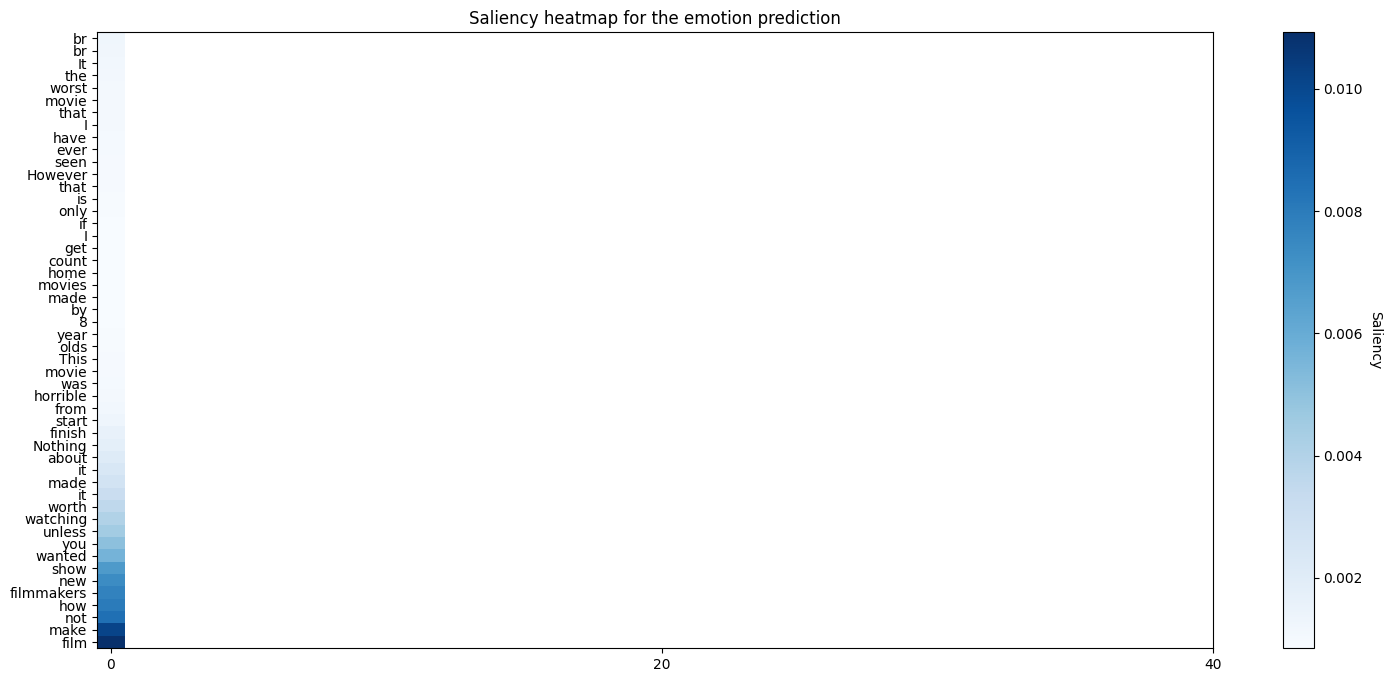

In [23]:
# create the figure
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
ax.set_aspect(aspect=2)
im = plt.imshow(saliency_list_module, aspect='auto', interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Saliency", rotation=-90, va="bottom")
ax.set_yticks(np.arange(len(useful_words)))
ax.set_xticks(np.arange(len(saliency_list_module), step=20))
ax.set_yticklabels(useful_words) # useful_words
ax.set_title("Saliency heatmap for the emotion prediction (norms of gradients)")
plt.show()


In [26]:
# now lets do the same with this sentence
texto_original = "This movie is the best to make me fall asleep. The actors are boring and the story is terrible."
text = texto_original.split(" ")

review = "This movie is the best to make me fall asleep. The actors are boring and the story is terrible"

# convert the text to a tensor
text_tensor = torch.tensor([w2v_model.key_to_index[word] for word in text if word in w2v_model]).unsqueeze(0).cuda()

# get the length of the text
length = torch.tensor([len(text)]).cuda()

# embed the text
embedded_text = embedding(text_tensor)

# get the gradients of the model
model.zero_grad()
out = model(embedded_text, length.cpu().int())
loss = loss_fn(out, torch.tensor([1]).cuda().float())
loss.backward()

# get the gradients of the model with respect to the input of the model
gradients = embedded_text.grad

# get the saliency map
saliency = gradients.data.abs().squeeze()
saliency_list = saliency.detach().cpu().numpy()

# get the output of the model
output = torch.sigmoid(out)
output = output.detach().cpu().numpy()

# get the words in the sentence
words = texto_original

# create the figure
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_aspect(aspect=2)
im = plt.imshow(saliency_list[0], aspect='auto', interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Saliency", rotation=-90, va="bottom")
ax.set_yticks(np.arange(len(words)))

ax.set_yticklabels(words)
ax.set_title("Saliency heatmap for the emotion prediction")
plt.show()


AttributeError: 'NoneType' object has no attribute 'data'